<font color='green'>
<br>
Методом подбора лучшей модели и оптимальных ее параметров мы добились хороших результатов.
<br>
Изучая опыт предыдущих товарищей я нашел квалификационную работу Седова Д.Э.
<br>
Он провел более широкие исследования влияния разных способов токенизации, лемматизации и классификации на метрики при калассификации текстов.
<br>
В целом мои результаты подтверждают его выводы.
<br>
И в его работе использование векторизации с использованием нейросетей word2vec не принесло рекордных результатов.
<br>
Самое лучшее соотношение скорости обучения к точности были
получены на паре TF-IDF + LinearSVC, практически как и в нашем случае.
<br>
Ссылка:
«Тольяттинский государственный университет»
Институт математики, физики и информационных технологий
<br>
   Д.Э. Седов
<br>    
ВЫПУСКНАЯ КВАЛИФИКАЦИОННАЯ РАБОТА
(БАКАЛАВРСКАЯ РАБОТА)
на тему «Разработка приложения для классификации текста»
<br>    
Тольятти 2022    
<br>
    Но я примения модель word2vec, обученную на совсем других данных.
<br>
    По общему мнению, новые предобученные модели на основе трансформеров, работают намного более удачно.
<br>
    Также работа Kiruthika Nallichery Subramanian и Thailambal Ganapath
<br>
    навела на мысль, что результат можно еще улучшить, используя для векторизации предобученный BERT, а затем классифицировать эти признаки в модели SVM
    <br>
    Ссылка на работу:
<br>    
    Облегченная система рекомендаций для анализа социальных сетей
с использованием гибридного алгоритма классификатора BERT-SVM
<br>
    Kiruthika Nallichery Subramanian, Thailambal Ganapathy
<br>
    Научно-технический вестник информационных технологий, механики и оптики, 2022, том 22, № 4
<br>
    https://ntv.ifmo.ru/file/article/21366.pdf?ysclid=llgbpfs3np236963695
<br>
    


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.3 MB/s eta 0:00:00


### 1. Импорт библиотек

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import regex
from tqdm import tqdm
import pickle
import os
import inspect
import sys
#from icecream import ic

In [ ]:
#base_dir = 'data_out'
base_dir = '/content/drive/MyDrive/Colab Notebooks/data_out'
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def save_pickle(obj, fname, dir=base_dir):
    full_fname = dir + '/' + fname
    with open(full_fname, 'wb') as pickle_file:
        pickle.dump(obj, pickle_file)
    print(f"saved \"{fname}\" ({sizeof_fmt(os.path.getsize(full_fname))}).")

def load_pickle(fname, dir=base_dir):
    full_fname = dir + '/' + fname
    with open(full_fname, 'rb') as pickle_file:
        obj = pickle.load(pickle_file)
    print(f"loaded \"{fname}\" ({sizeof_fmt(os.path.getsize(full_fname))}).")
    return obj

### 2. Загрузка заранее предобработанных данных

In [ ]:
#train_df = pd.read_csv('data_out/train_df.csv')
#val_df = pd.read_csv('data_out/val_df.csv')

train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_out/train_df.csv')
val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_out/val_df.csv')

#train_df.head()

In [ ]:
train_df.sentiment.unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

In [ ]:
train_df[0] = train_df['Tweet content']

In [ ]:
val_df[0] = val_df['Tweet content']

In [ ]:
lab_enc = LabelEncoder()
train_df[1] = lab_enc.fit_transform(train_df['sentiment'])

In [ ]:
lab_enc = LabelEncoder()
val_df[1] = lab_enc.fit_transform(val_df['sentiment'])

In [ ]:
df_train = train_df[[0, 1]]

In [ ]:
df_val = val_df[[0, 1]]

### 3. Загрузка предобученной  BERT модели.

In [ ]:
# For DistilBERT:
#model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

### 4.	Токенизация.

In [ ]:
#tokenized = batch_1[0].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

In [ ]:
tokenized_train = df_train[0].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

In [ ]:
tokenized_val = df_val[0].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

In [ ]:
#tokenized[:5] # индексы токенов в классе токенизатора

### 5.	Paddingо.

<font color='green'>
        Выравниваем предложения по длине с помощью нулевых токенов.
<br>

In [ ]:
# находим самое длинное предложение
max_len = 0
for i in tokenized_train.values:
    if len(i) > max_len:
        max_len = len(i)

# заполняем обучающие данные, где не хватает длины до максимума -- добавляем нули
padded_train = np.array([i + [0]*(max_len-len(i)) for i in tokenized_train.values])

In [ ]:
# находим самое длинное предложение
max_len = 0
for i in tokenized_val.values:
    if len(i) > max_len:
        max_len = len(i)

# заполняем обучающие данные, где не хватает длины до максимума -- добавляем нули
padded_val = np.array([i + [0]*(max_len-len(i)) for i in tokenized_val.values])

In [ ]:
# находим самое длинное предложение
#max_len = 0
#for i in tokenized.values:
#    if len(i) > max_len:
#        max_len = len(i)
#
# заполняем обучающие данные, где не хватает длины до максимума -- добавляем нули
#padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
np.array(padded_train).shape, np.array(padded_val).shape

((70198, 315), (998, 125))

In [ ]:
padded_train[0]

array([ 101, 1045, 2572, 2746, 2000, 1996, 6645, 1998, 1045, 2097, 3102,
       2017, 2035, 1010,  102,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### 6.	Masking.

In [ ]:
attention_mask_train = np.where(padded_train != 0, 1, 0)
attention_mask_train.shape

(70198, 315)

In [ ]:
attention_mask_val = np.where(padded_val != 0, 1, 0)
attention_mask_val.shape

(998, 125)

In [ ]:
#attention_mask = np.where(padded != 0, 1, 0)
#attention_mask.shape

In [ ]:
attention_mask_val

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

### 7.	Используем BERT.

In [ ]:
model.to('cuda')
#model.to('cpu')

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [ ]:
padded_train = torch.tensor(padded_train)
attention_mask_train = torch.tensor(attention_mask_train)

### 8. Создадим загрузчики данных

In [ ]:
train_data = TensorDataset(padded_train, attention_mask_train)

In [ ]:
batch_size = 32

train_data_dataloader = DataLoader(
        train_data,  # Тренировочный набор данных.
        sampler = SequentialSampler(train_data), # Выбираем батчи последовательно
        batch_size = batch_size # Тренируем с таким размером батча.
)


In [ ]:
features = []
with torch.no_grad():

  for data in train_data_dataloader:
    padded_train_i, attention_mask_train_i = data

    last_hidden_states = model(padded_train_i.to('cuda'), attention_mask=attention_mask_train_i.to('cuda'))
    #last_hidden_states = model(padded_train_i.to('cpu'), attention_mask=attention_mask_train_i.to('cpu'))

    features.append(last_hidden_states[0][:,0,:].to('cpu').numpy())


In [ ]:
#features_train = np.vstack(features)
features_train = np.concatenate(features)

In [ ]:
features_train.shape


(70198, 768)

In [ ]:
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      | 457955 KiB |   1195 MiB |  32304 GiB |  32304 GiB |\n|       from large pool | 457398 KiB |   1194 MiB |  32140 GiB |  32140 GiB |\n|       from small pool |    557 KiB |      1 MiB |    163 GiB |    163 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         | 457955 KiB |   1195 MiB |  32304 GiB |  32304 GiB |\n|       from large pool | 457398 KiB |   1194 MiB |

In [ ]:
#torch.cuda.empty_cache()

In [ ]:
#import gc
#del variables
#gc.collect()

In [ ]:
#last_hidden_states[0].shape

In [ ]:
#features = last_hidden_states[0][:,0,:].to('cpu').numpy()

Метки:

In [ ]:
labels_train = df_train[1]

### 9. Применение модели SVC на признаках из BERT и оценка результатов.

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features_train, labels_train)

In [ ]:
%%time
svm = SVC(kernel='poly', gamma='scale')
svm.fit(train_features, train_labels)

CPU times: user 23min 40s, sys: 2.16 s, total: 23min 42s
Wall time: 23min 44s


SVC(kernel='poly')

<font color='green'>
        Оценим предсказания SVM модели.
<br>

In [ ]:
test_labels_pred = svm.predict(test_features)

accuracy = accuracy_score(test_labels, test_labels_pred)
report = classification_report(test_labels, test_labels_pred)

print('Accuracy:', accuracy)
print('Classification Report:')
print(report)

Accuracy: 0.6994871794871795
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      5383
           1       0.69      0.73      0.71      7413
           2       0.69      0.63      0.66      4754

    accuracy                           0.70     17550
   macro avg       0.70      0.69      0.70     17550
weighted avg       0.70      0.70      0.70     17550



<font color='green'>
        Оценим предсказания SVM модели на валидационной выборке.
<br>

In [ ]:
padded_val = torch.tensor(padded_val)
attention_mask_val = torch.tensor(attention_mask_val)

### 8. Создадим загрузчики данных

In [ ]:
train_data_val = TensorDataset(padded_val, attention_mask_val)

In [ ]:
batch_size = 32

train_data_val_dataloader = DataLoader(
        train_data_val,  # Тренировочный набор данных.
        sampler = SequentialSampler(train_data_val), # Выбираем батчи последовательно
        batch_size = batch_size # Тренируем с таким размером батча.
)


In [ ]:
features_val = []
with torch.no_grad():

  for data in train_data_val_dataloader:
    padded_train_i, attention_mask_train_i = data

    last_hidden_states = model(padded_train_i.to('cuda'), attention_mask=attention_mask_train_i.to('cuda'))
    #last_hidden_states = model(padded_train_i.to('cuda'), attention_mask=attention_mask_train_i.to('cuda'))

    features_val.append(last_hidden_states[0][:,0,:].to('cpu').numpy())


In [ ]:
#features_val = np.vstack(features_val)
features_val = np.concatenate(features_val)


In [ ]:
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      | 451463 KiB |   1195 MiB |  32436 GiB |  32435 GiB |\n|       from large pool | 450858 KiB |   1194 MiB |  32269 GiB |  32269 GiB |\n|       from small pool |    605 KiB |      1 MiB |    166 GiB |    166 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         | 451463 KiB |   1195 MiB |  32436 GiB |  32435 GiB |\n|       from large pool | 450858 KiB |   1194 MiB |

In [ ]:
#torch.cuda.empty_cache()

In [ ]:
#import gc
#del variables
#gc.collect()

In [ ]:
#last_hidden_states[0].shape

In [ ]:
#features = last_hidden_states[0][:,0,:].to('cpu').numpy()

Метки:

In [ ]:
labels_val = df_val[1]

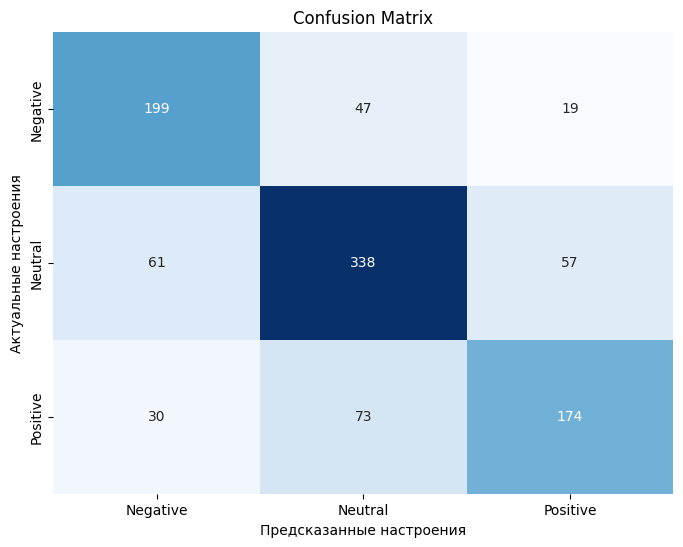

              precision    recall  f1-score   support

           0       0.69      0.75      0.72       265
           1       0.74      0.74      0.74       456
           2       0.70      0.63      0.66       277

    accuracy                           0.71       998
   macro avg       0.71      0.71      0.71       998
weighted avg       0.71      0.71      0.71       998

Accuracy: 0.7124248496993988


In [ ]:
#y_valid_data_pred = lab_enc.inverse_transform(svm.predict(features_val))
labels_val_pred = svm.predict(features_val)

pred_df = pd.DataFrame({'Predicted Sentiment': labels_val_pred})
pred_df.to_csv('predicted_sentiments_BERT.csv', index=False)

accuracy = accuracy_score(labels_val, labels_val_pred)

confusion = confusion_matrix(labels_val, labels_val_pred)

classification = classification_report(labels_val, labels_val_pred)

#le = LabelEncoder()
#le.fit(val_df['sentiment'])

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=lab_enc.classes_, yticklabels=lab_enc.classes_)
plt.xlabel('Предсказанные настроения')
plt.ylabel('Актуальные настроения')
plt.title('Confusion Matrix')
plt.show()


print(classification)
print('Accuracy:', accuracy)


<font color='green'>
Результат уже лучше 0,7 , но все равно не блестящий.
<br>
Есть куда совершенствоваться.
<br>
С 0,97 на SVM с TF-IDF не сравнить.